# About

This is my notebook for the Tabular Playground Series - June 2021 using XGBoost. I have a [seperate notebook for my EDA](https://www.kaggle.com/melanie7744/tps6-eda-comparison-to-tps5).

I frist ran the same XGBoost configuration as for TPS5. Then I 
* experimented with different types of duplicates present or removed from the training set ---> I got a slightly better result without the duplicates in the training set
* added new features based on:
    * KNN feature extraction (uses the gokinjo package) ---> improvement in score
    * Kmeans clustering (cluster label and cluster distance) ---> no improvement in score
* applied a stepwise tuning approach using GridSearchCV ---> good improvement in validation score

The results are listed as comments below. It was an iterative process with the current version of the notebook only showing the last step.


In [1]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

import sklearn # machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV 

import xgboost as xgb
print("xgb version: {}". format(xgb.__version__))
from xgboost import plot_importance


# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

matplotlib version: 3.4.1
scikit-learn version: 0.24.1
xgb version: 1.4.0
/kaggle/input/tps6-kmeans-features/__results__.html
/kaggle/input/tps6-kmeans-features/__notebook__.ipynb
/kaggle/input/tps6-kmeans-features/kmeans_features.csv
/kaggle/input/tps6-kmeans-features/__output__.json
/kaggle/input/tps6-kmeans-features/custom.css
/kaggle/input/tps6-kmeans-features/__results___files/__results___5_0.png
/kaggle/input/tps6-kmeans-features/__results___files/__results___6_0.png
/kaggle/input/tabular-playground-series-jun-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-jun-2021/train.csv
/kaggle/input/tabular-playground-series-jun-2021/test.csv
/kaggle/input/tps6-boost-your-score-with-knn-features/__results__.html
/kaggle/input/tps6-boost-your-score-with-knn-features/add_feat_train.npy
/kaggle/input/tps6-boost-your-score-with-knn-features/__notebook__.ipynb
/kaggle/input/tps6-boost-your-score-with-knn-features/__output__.json
/kaggle/input/tps6-boost-your-score-with-knn-fe

## Load data

In [2]:
df_train = pd.read_csv('../input/tabular-playground-series-jun-2021/train.csv')
df_test = pd.read_csv('../input/tabular-playground-series-jun-2021/test.csv')
sample_submission = pd.read_csv('../input/tabular-playground-series-jun-2021/sample_submission.csv') 

# label encode the target column
le = LabelEncoder()
df_train.target = le.fit_transform(df_train.target)

features = [col for col in df_train.columns if col.startswith("feature")]
class_lables = [f'Class_{i}' for i in range(1, 10)]
#class_lables = ['Class_' + str(i) for i in range(10)]
#class_labels = ["Class_1","Class_2","Class_3","Class_4","Class_5","Class_6","Class_7","Class_8","Class_9"]

df_train[features].head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
0,0,0,6,1,0,0,0,0,7,0,...,3,0,0,0,0,0,0,2,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,3,0,0,...,8,0,0,0,0,1,0,0,0,0
3,0,0,7,0,1,5,2,2,0,1,...,0,0,4,0,2,2,0,4,3,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# load additional features
# kmeans_features = pd.read_csv('../input/tps6-kmeans-features/kmeans_features.csv') # not used anymore, score was worse
KNN_feat_train = np.load('../input/tps6-boost-your-score-with-knn-features/add_feat_train.npy')
KNN_feat_test = np.load('../input/tps6-boost-your-score-with-knn-features/add_feat_test.npy')

In [4]:
# add additional features to train and test data
# add kmeans to train and test
#df_train = df_train.join(kmeans_features[0:df_train.shape[0]])
#display(df_train.shape)

#kmea_test = kmeans_features[df_train.shape[0]:df_train.shape[0]+df_test.shape[0]].reset_index().rename(columns={"index":"id"})
#df_test = df_test.merge(kmea_test, on="id")
#display(df_test.shape)

# add KNN to train and test
col_names=[f'KNN_{i}' for i in range(0,np.shape(KNN_feat_train)[1])]
KNN_train = pd.DataFrame(data=KNN_feat_train, columns=col_names)
df_train = df_train.join(KNN_train)
display(df_train.shape)

KNN_test = pd.DataFrame(data=KNN_feat_test, columns=col_names)
df_test = df_test.join(KNN_test)
display(df_test.shape)

(200000, 86)

(100000, 85)

## Handle duplicates

In [5]:
# drop duplicates, play around here, kick differnt type of duplicates out, or non at all
#display(df_train[df_train[features].duplicated(keep="first")])
df_train= df_train.drop_duplicates(subset = features)
display(df_train.shape)

(199776, 86)

## Prepare the data for modelling

In [6]:
# prepare test data
df_test.head()
X_test=df_test.drop(columns="id")
X_test.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_74,KNN_0,KNN_1,KNN_2,KNN_3,KNN_4,KNN_5,KNN_6,KNN_7,KNN_8
0,0,0,0,0,0,0,0,0,0,0,...,0,0.547604,0.389433,0.392643,0.584082,0.603959,0.463100,0.590595,0.602523,0.514352
1,1,2,0,0,0,0,0,0,0,0,...,0,2.285586,2.231189,2.220028,2.356438,2.156877,2.252686,2.348384,2.286211,2.110849
2,0,1,7,1,0,0,0,0,6,0,...,0,2.596313,2.417132,2.631729,2.721614,2.677561,2.286485,2.815163,2.517098,2.400451
3,0,0,0,4,3,1,0,0,0,0,...,0,3.477178,3.821449,4.083416,4.074107,4.037642,3.600940,3.889824,3.747779,3.639647
4,0,0,5,0,0,0,0,0,0,8,...,0,3.220989,2.335625,3.338280,3.301072,3.844479,3.187928,3.367527,2.923119,3.107001


In [7]:
# define X and y
X = df_train.drop(columns=["id","target"])
y = df_train.target
display(X.shape)

(199776, 84)

In [8]:
# dividing X, y into train and test data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0, stratify=y)
display(X_train.shape)

(149832, 84)

## Stepwise hyperparameter tuning

The search for optimal hyperparameters can be very time consuming. Therefore I decided to use a stepwise approach. If a parameter was at the end of the search spectrum, I started a new GridSearch with a new search range. Each time a hyperparameter was considered "optimal" the XGBClassifier in GridSearch was updated with the optimal value.

I started with a parameter set of:
* max_depth = 5
* min_child_weight =1
* gamma = 0
* subsample = 0.8
* colsample_bytree = 0.8
* reg_lambda = 1 (default)

In the first iterations I used GridSearach to get optimal **tree-specific parameters** for
* max_depth & min_child_weight
* gamma
* subsample & colsample_bytree

Then I tuned the **regularization** parameter lambda.

Hyperparameter optimization had a good effect:
* before tuning the logloss on the validation set was 1.75040
* after tuning the logloss on the validation set was 1.74722

In [9]:
# Grid Search for better hyperparameters
# Round 1: get indication on best max_depth and min_child_weight -> {'max_depth': 3, 'min_child_weight': 5}
param_grid = {
     'max_depth': range(3,10,2), 
     'min_child_weight': range(1,6,2)
 }

# Round 2: fine tune max_depth and min_child_weight -> {'max_depth': 3, 'min_child_weight': 4}
param_grid = {
     'max_depth': [2,3,4], 
     'min_child_weight': [4,5,6]
 }

# Round 3: tune gamma -> {'gamma': 0.3}
param_grid = {
     #'gamma': [0, 0.1, 0.2, 0.3]
     'gamma': [0.3, 0.4, 0.5]
}
# Round 4: tune subsample and colsample_bytree -> {'colsample_bytree': 0.8, 'subsample': 0.9}, -1.7503138502172977
param_grid = {
     #'subsample': [0.7, 0.8, 0.9],
     #'colsample_bytree': [0.7, 0.8, 0.9]
     'subsample': [0.9, 0.95, 1]
}
# Round 5: Tune Regularization -> {'reg_lambda': 200} -1.7490307873359994
param_grid = {
     #'reg_lambda' : [0.01, 0.1, 1, 10, 20] 
     'reg_lambda' : [50, 100, 150, 200, 250, 300] 
 }
optimal_params = GridSearchCV(
     estimator=xgb.XGBClassifier(
                            objective='multi:softprob',                        
                            seed=42, 
                            use_label_encoder=False, 
                            num_class=9, 
                            colsample_bytree=0.8, 
                            subsample=0.9,
                            eta=0.1,
                            gamma = 0.3,
                            max_depth = 3,
                            min_child_weight=4,
                            n_estimators = 200,
                            eval_metric=['mlogloss']
                            ),    
     param_grid=param_grid,
     scoring = 'neg_log_loss',
     verbose=0, # NOTE: If you want to see what Grid Search is doing, set verbose=2
     cv = 3
 )

In [10]:
# uncomment to start GridSearch, time consuming!
#optimal_params.fit(X_train,y_train,early_stopping_rounds=30,eval_set=[(X_val, y_val)],verbose=50)
#print(optimal_params.best_params_)
#print(optimal_params.best_score_)

## Retrain with optimal hyperparameters

In [11]:
# re-train model with complete training set 
clf_xgb = xgb.XGBClassifier(objective='multi:softprob', 
                            seed=42, 
                            use_label_encoder=False, 
                            num_class=9, 
                            colsample_bytree=0.8, 
                            subsample=0.9,
                            eta=0.1,
                            gamma = 0.3,
                            max_depth = 3,
                            min_child_weight=4,
                            n_estimators = 500,
                            eval_metric=['mlogloss'],
                            reg_lambda = 200
                            )
clf_xgb.fit(X, 
            y,
            verbose=10,
            ## the next three arguments set up early stopping.
            early_stopping_rounds=50,
            eval_metric=['mlogloss'],
            eval_set=[(X, y)]
           )

[0]	validation_0-mlogloss:2.15006
[10]	validation_0-mlogloss:1.90701
[20]	validation_0-mlogloss:1.82174
[30]	validation_0-mlogloss:1.78562
[40]	validation_0-mlogloss:1.76843
[50]	validation_0-mlogloss:1.75917
[60]	validation_0-mlogloss:1.75342
[70]	validation_0-mlogloss:1.74944
[80]	validation_0-mlogloss:1.74640
[90]	validation_0-mlogloss:1.74397
[100]	validation_0-mlogloss:1.74192
[110]	validation_0-mlogloss:1.74014
[120]	validation_0-mlogloss:1.73858
[130]	validation_0-mlogloss:1.73717
[140]	validation_0-mlogloss:1.73589
[150]	validation_0-mlogloss:1.73474
[160]	validation_0-mlogloss:1.73365
[170]	validation_0-mlogloss:1.73267
[180]	validation_0-mlogloss:1.73172
[190]	validation_0-mlogloss:1.73082
[200]	validation_0-mlogloss:1.72996
[210]	validation_0-mlogloss:1.72916
[220]	validation_0-mlogloss:1.72839
[230]	validation_0-mlogloss:1.72765
[240]	validation_0-mlogloss:1.72691
[250]	validation_0-mlogloss:1.72622
[260]	validation_0-mlogloss:1.72557
[270]	validation_0-mlogloss:1.72492
[28

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.1,
              eval_metric=['mlogloss'], gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=3,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=4, num_class=9, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=200, scale_pos_weight=None, seed=42, subsample=0.9,
              tree_method='exact', use_label_encoder=False, ...)

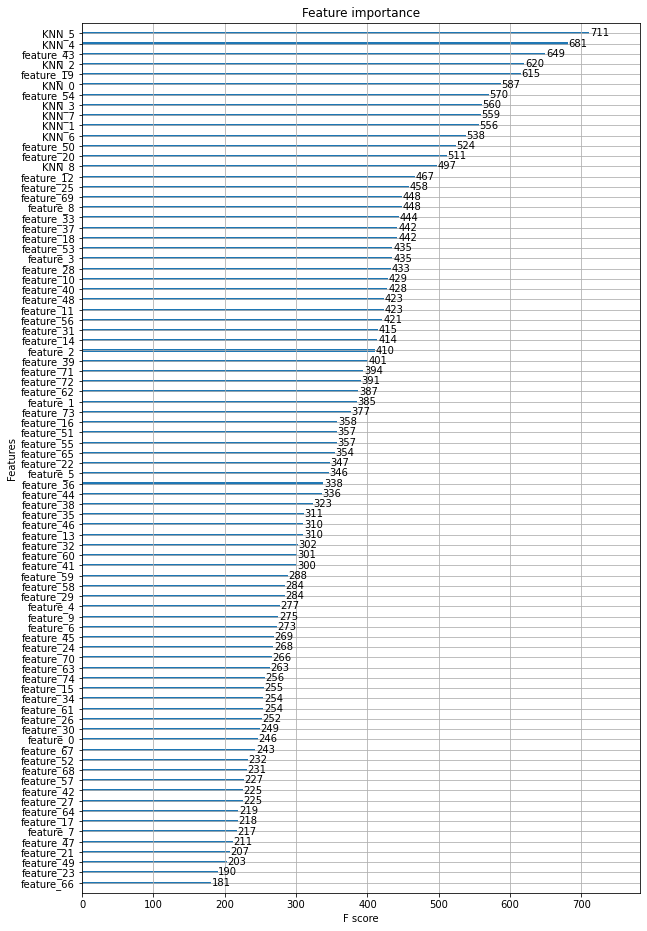

In [12]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(clf_xgb,(10,16) )
plt.show()

Here we can see, that XGBoost ranks the KNN features as top priority for it's decisions.

## Predict for test data

In [13]:
# predict
predictions = clf_xgb.predict_proba(X_test) 
predictions

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


array([[0.04418975, 0.41844228, 0.17966935, ..., 0.01790319, 0.03661164,
        0.10006852],
       [0.03547624, 0.09146914, 0.07177109, ..., 0.06572427, 0.29767165,
        0.11735529],
       [0.02155669, 0.02724217, 0.0216287 , ..., 0.02945044, 0.12905723,
        0.05970404],
       ...,
       [0.08191795, 0.2776949 , 0.1353544 , ..., 0.03976572, 0.11373071,
        0.13362424],
       [0.03225777, 0.0175032 , 0.01961933, ..., 0.06585106, 0.34253734,
        0.07626279],
       [0.04762298, 0.08412846, 0.07287895, ..., 0.09007377, 0.23441258,
        0.14679137]], dtype=float32)

## Prepare submission

In [14]:
# create submission file
class_labels = ["Class_1","Class_2","Class_3","Class_4","Class_5","Class_6","Class_7","Class_8","Class_9"]

submission = pd.merge(sample_submission.id, (pd.DataFrame(data=predictions, columns=class_lables)), left_index=True, right_index=True)
submission.to_csv("my_submission.csv", index=False)

submission

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,0.044190,0.418442,0.179669,0.027011,0.012923,0.163182,0.017903,0.036612,0.100069
1,200001,0.035476,0.091469,0.071771,0.014084,0.014786,0.291663,0.065724,0.297672,0.117355
2,200002,0.021557,0.027242,0.021629,0.011438,0.005792,0.694131,0.029450,0.129057,0.059704
3,200003,0.048692,0.119561,0.091345,0.051305,0.014758,0.180356,0.088753,0.223347,0.181882
4,200004,0.033438,0.097986,0.083861,0.031484,0.018246,0.318640,0.064063,0.207366,0.144917
...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.061761,0.398073,0.142400,0.028968,0.015064,0.098417,0.036067,0.069744,0.149506
99996,299996,0.045740,0.265622,0.128011,0.019518,0.016038,0.166017,0.041656,0.171982,0.145417
99997,299997,0.081918,0.277695,0.135354,0.030281,0.012046,0.175585,0.039766,0.113731,0.133624
99998,299998,0.032258,0.017503,0.019619,0.009300,0.010899,0.425770,0.065851,0.342537,0.076263


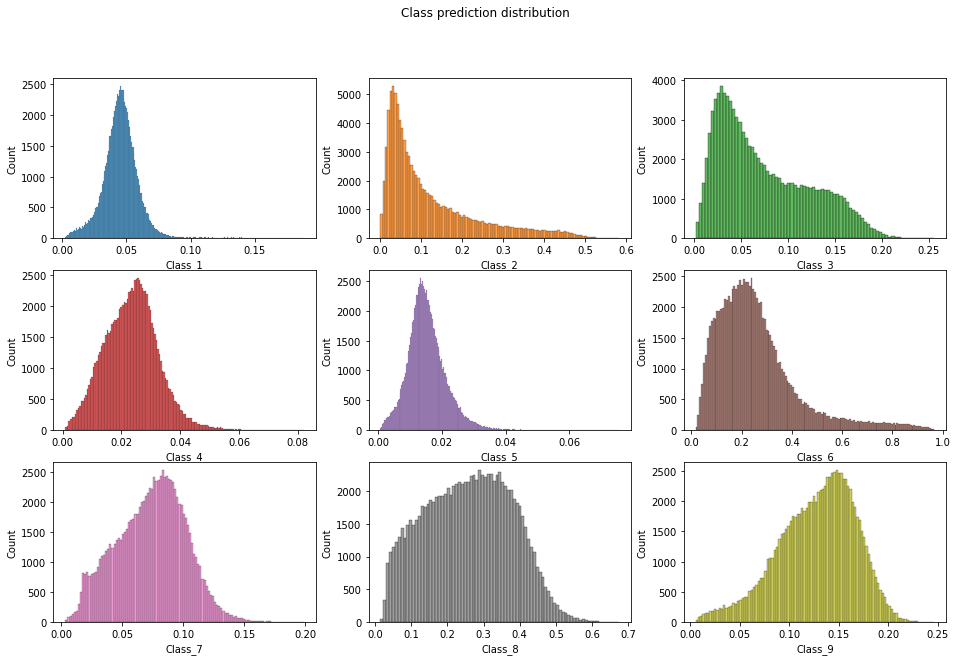

In [15]:
# code from Remek Kinas
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

palette = itertools.cycle(sns.color_palette())

plt.figure(figsize=(16, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    c = next(palette)
    sns.histplot(submission, x = f'Class_{i+1}', color=c)
plt.suptitle("Class prediction distribution")

plt.show()